In [23]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.extmath import softmax
from sklearn.inspection import permutation_importance
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
# Helper function to extract data from text files
def load_data(file_pattern):
    data = []
    record_ids = []
    for root, _, files in os.walk("../process/PROCESS-V1/"):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                # Extract record ID from the file path
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

In [25]:
# Helper function to load Class labels
def load_labels(label_file):
    df = pd.read_csv(label_file)
    df['label'] = df['Class']  # Verwende die Klasse direkt aus der Spalte 'Class'
    label_map = df.set_index('Record-ID')['label'].to_dict()
    return label_map

In [26]:
# Helper function to check if a word is an animal
def is_animal(word):
    for synset in wn.synsets(word, pos=wn.NOUN):
        if 'animal' in synset.lexname():
            return True
    return False

# Function to count interrupters (excluding 'second' and 'seconds') and remove other parentheses content
def count_interrupters_and_clean_text(text):
    words_in_parentheses = re.findall(r'\((.*?)\)', text)  # Extract content in parentheses
    interrupter_count = 0
    cleaned_text = text
    for entry in words_in_parentheses:
        # Skip empty parentheses or those with only spaces
        if not entry.strip():
            cleaned_text = cleaned_text.replace(f'({entry})', '')
            continue
        # Exclude 'second' and 'seconds' only if they are the sole content
        if re.fullmatch(r'\d+ seconds?', entry.strip()):
            continue  # Keep these parentheses in the text
        else:
            # Find valid words and exclude numbers
            tokens = re.findall(r'\b[a-zA-Z]+\b', entry)
            interrupter_count += len(tokens)
            # Remove this specific parentheses content
            cleaned_text = cleaned_text.replace(f'({entry})', '')
    return interrupter_count, cleaned_text

# Feature engineering: Identify repetitive patterns and calculate timing features
def find_repetitions_and_timing(text):
    # Count interrupters and clean the text
    interrupter_count, cleaned_text = count_interrupters_and_clean_text(text)
    
    #Remove "Pat:" from text
    text = re.sub(r'Pat:\s*', '', text)
    
    # Remove parentheses content from text (exclude interruptions)
    cleaned_text = re.sub(r'\(.*?\)', '', text)
    

    # Extract gaps and calculate pauses
    gaps = [int(gap) for gap in re.findall(r'\((\d+) seconds\)', text)]
    initial_pause = gaps[0] if gaps else 0  # Time before the first word
    pause_variation = pd.Series(gaps).std() if len(gaps) > 1 else 0

    # Calculate word-related features
    words = re.findall(r'\b\w+\b', cleaned_text)
    stutter_specific_words = len(re.findall(r'\b(er|um|oh|ohh|mm)\b', cleaned_text))
    meaningful_words = len(words) - stutter_specific_words

    # Calculate ratios
    words_to_pause_ratio = len(words) / (sum(gaps) + interrupter_count) if sum(gaps) > 0 else 0
    meaningful_to_stutter_ratio = meaningful_words / stutter_specific_words if stutter_specific_words > 0 else 0

    #animal words
    animal_words = [word for word in words if is_animal(word)]  # Words identified as animals
    animal_count = len(animal_words)
    repeated_animal_words = len([word for word in words if words.count(word) > 1])
    unique_animal_words = len(set(animal_words))
    unique_to_repeated_ratio = unique_animal_words / repeated_animal_words if repeated_animal_words > 0 else 0
    
    
    return {
        'animal_count': animal_count, # hoch ist gut
        'total_words': len(words), # hoch ist gut
        'stutter_specific_words': stutter_specific_words, # niedrig ist gut
        'repeated_animal_words': repeated_animal_words, # niedrig ist gut
        'avg_gap': sum(gaps) / len(gaps) if gaps else 0, # niedrig ist gut
        'words_to_pause_ratio': words_to_pause_ratio, # hoch ist gut
        'meaningful_to_stutter_ratio': meaningful_to_stutter_ratio, # hoch ist gut (Verhältnis relevante zu Stotterwörter)
        'unique_to_repeated_ratio': unique_to_repeated_ratio, # hoch ist gut (Verhältnis von einzigartigen zu wiederholten Wörtern)
        'initial_pause': initial_pause, # niedrig ist gut (Zeit bis zum ersten Wort)
        'pause_variation': pause_variation, # niedrig ist gut (Standardabweichung der Sprechpausen)
        'interrupter_count': interrupter_count # niedrig ist gut
    }

# Apply feature extraction to the dataset
def extract_features(texts):
    feature_list = []
    for text in texts:
        features = find_repetitions_and_timing(text)
        feature_list.append(features)
    features_df = pd.DataFrame(feature_list)
    print("Extracted features:")
    print(features_df.head())  # Output intermediate features for verification
    return features_df


In [27]:
# Load the MMSE labels
label_file = "../process/PROCESS-V1/dem-info.csv"
labels = load_labels(label_file)

# Load the data
file_pattern = r"Process-rec-\d+__SFT\.txt"
data, record_ids = load_data(file_pattern)


In [28]:
# Map labels to data
y = [labels.get(record_id, 0) for record_id in record_ids]  # Default to 0 (Not affected) if no label exists

if not data or not y:
    raise ValueError("No matching data or labels found. Check your file paths or label mapping.")

In [29]:
# Split data and labels into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

# Split record IDs to match the test data
_, test_record_ids = train_test_split(record_ids, test_size=0.2, random_state=42)


In [30]:
# Extract features
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

Extracted features:
   animal_count  total_words  stutter_specific_words  repeated_animal_words  \
0            32           57                      13                     24   
1            18           29                       3                      9   
2            24           24                       0                      0   
3            24           52                      17                     23   
4            21           21                       0                      0   

    avg_gap  words_to_pause_ratio  meaningful_to_stutter_ratio  \
0  2.000000              9.500000                     3.384615   
1  6.500000              2.230769                     8.666667   
2  5.250000              1.090909                     0.000000   
3  0.000000              0.000000                     2.058824   
4  2.666667              1.312500                     0.000000   

   unique_to_repeated_ratio  initial_pause  pause_variation  interrupter_count  
0                  1.291667

In [31]:
from sklearn.preprocessing import StandardScaler

# Create a simple ML pipeline with Naive Bayes as baseline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', MultinomialNB())
])

In [32]:
# Fit the model
pipeline.fit(X_train_features, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', MultinomialNB())])

Calculating Permutation Importance...


C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.wa

Top Features by Importance:
                        Feature  Importance
3         repeated_animal_words    0.003125
10            interrupter_count    0.003125
7      unique_to_repeated_ratio    0.000000
8                 initial_pause    0.000000
2        stutter_specific_words   -0.015625
5          words_to_pause_ratio   -0.018750
4                       avg_gap   -0.021875
9               pause_variation   -0.028125
1                   total_words   -0.028125
0                  animal_count   -0.034375
6   meaningful_to_stutter_ratio   -0.043750
              precision    recall  f1-score   support

    Dementia       0.00      0.00      0.00         2
          HC       0.65      0.85      0.74        20
         MCI       0.33      0.20      0.25        10

    accuracy                           0.59        32
   macro avg       0.33      0.35      0.33        32
weighted avg       0.51      0.59      0.54        32



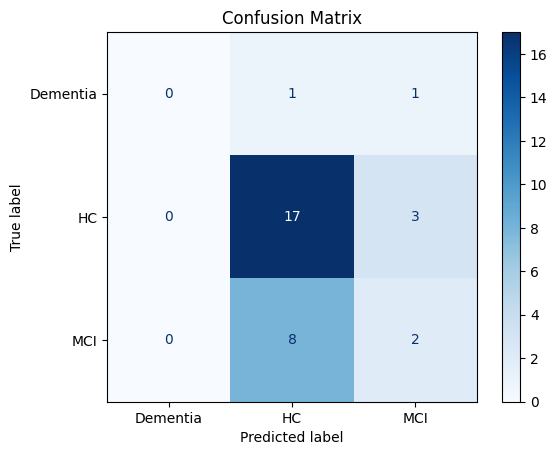

In [33]:
# Predict on test data
y_pred = pipeline.predict(X_test_features)

# Check the range of vectorized test data
#vectorized_test = pipeline.named_steps['vectorizer'].transform(X_test)
#print("Vectorized Test Data Range:", vectorized_test.min(), vectorized_test.max())


# Berechne die Permutation Importance
print("Calculating Permutation Importance...")
perm_importances = permutation_importance(
    pipeline.named_steps['classifier'],  # Das Modell
    X_test_features,                     # Testdaten
    y_test,                              # Labels
    n_repeats=10,                        # Wiederholungen zur Stabilität
    random_state=42
)

# Erstelle eine DataFrame mit den Features und ihrer Bedeutung
feature_importances_df = pd.DataFrame({
    'Feature': X_test_features.columns,
    'Importance': perm_importances.importances_mean
}).sort_values(by='Importance', ascending=False)

# Ausgabe der wichtigsten Features
print("Top Features by Importance:")
print(feature_importances_df)

# Speichere die Feature-Bedeutung zur weiteren Analyse
feature_importances_df.to_csv("SFT-feature_importances.csv", index=False)



# Evaluate the model
print(classification_report(y_test, y_pred))

# Save features for debugging
X_train_features['label'] = y_train
X_test_features['label'] = y_test

# Save processed data for review
X_train_features.to_csv("SFT-train_features.csv", index=False)
X_test_features.to_csv("SFT-test_features.csv", index=False)

# Save predictions and scores for review
predictions_with_scores_df = pd.DataFrame({
    'record_id': test_record_ids,
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred,
})    #'score_0': probabilities[:, 0],
    #'score_1': probabilities[:, 1]


predictions_with_scores_df.to_csv("SFT-predictions_with_scores_NaiveBayes.csv", index=False)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()